<a href="https://colab.research.google.com/github/JonMcEntee/hm-fashion-recommendations/blob/main/H%26M_Fashion_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

In [2]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# H&M Fashion Recommendations

This notebook details my approach to Kaggle's [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview) competition, focused on predicting customers' next fashion purchases. With vast product selections becoming standard in retail, delivering precisely tailored suggestions is key to enhancing shopping experiences and brand loyalty in modern fashion commerce.

In [123]:
articles = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")\
  #.sample(frac=0.01, random_state=random_seed)

In [114]:
# Trick to reduce size in memory
customer_id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
# customer_index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))

transactions["customer_id"] = transactions["customer_id"].map(customer_id_to_index_dict)
customers["customer_id"] = customers["customer_id"].map(customer_id_to_index_dict)

article_id_to_index_dict = dict(zip(articles["article_id"], customers.index))
# article_index_to_id_dict = dict(zip(customers.index, articles["article_id"]))

transactions["article_id"] = transactions["article_id"].map(article_id_to_index_dict)
articles["article_id"] = articles["article_id"].map(article_id_to_index_dict)

transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Exploratory Data Analysis

Lets first examine the data and understand how it is distributed. We will start by looking at what articles are being sold and in what frequency

In [116]:
article_details = pd.merge(transactions,
                           articles[["article_id",
                                     "product_type_name",
                                     "product_group_name"]],
                           how="left", on="article_id")

product_types = article_details.groupby("product_type_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

product_groups = article_details.groupby("product_group_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

del article_details

We can see that as a group upper body clothing is the most popular seller, though in individual product type trousers come out first.

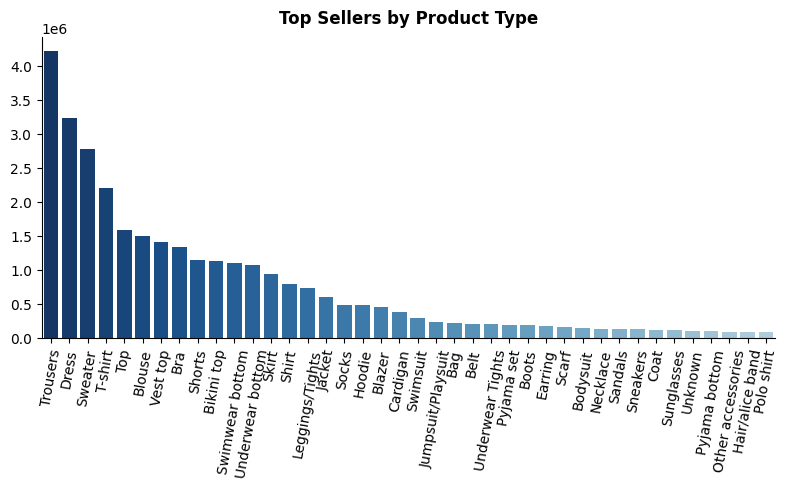

In [87]:
plt.figure(figsize=(8, 5))
num_categories=40
custom_palette = sns.color_palette('Blues', num_categories + 20)[20:][::-1]
g = sns.barplot(product_types.head(num_categories), x = "product_type_name", y = "count", hue="product_type_name", palette=custom_palette)
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Type", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()

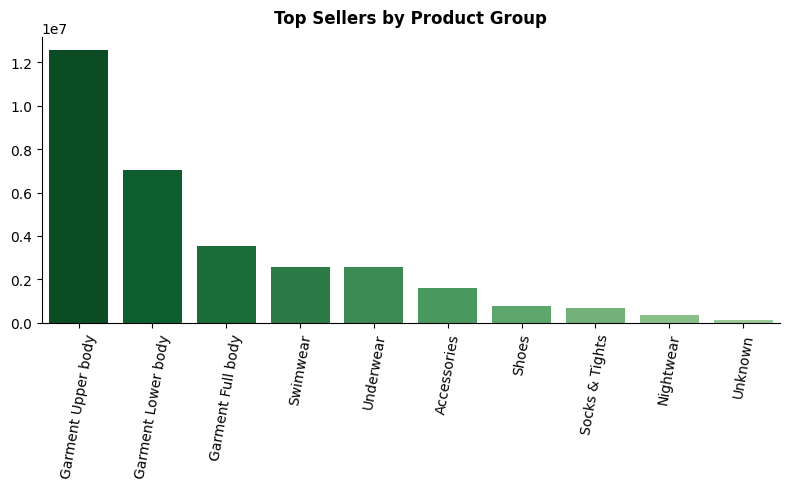

In [89]:
plt.figure(figsize=(8, 5))
num_categories=10
custom_palette = sns.color_palette('Greens', num_categories + 6)[6:][::-1]
g = sns.barplot(product_groups.head(num_categories), x = "product_group_name", y = "count", hue="product_group_name", palette=custom_palette)
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Group", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()

We can see that the amount of purchases over time does not seem to be growing or decreasing on average.

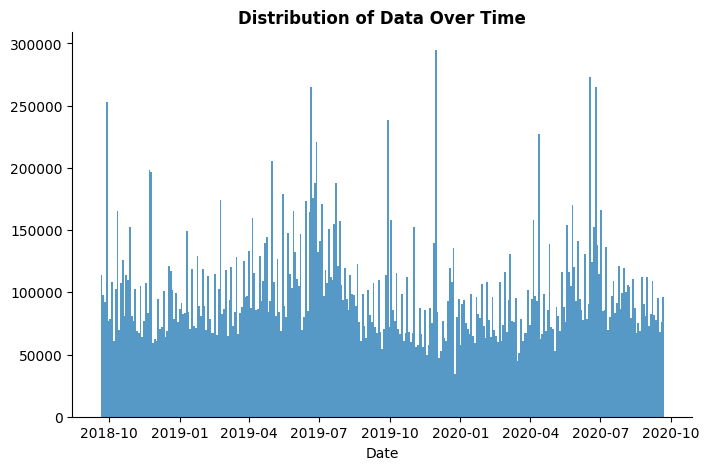

In [111]:
plt.figure(figsize=(8, 5))
g = sns.histplot(transactions,
                 x = "t_dat",
                 edgecolor=None,
                 bins=100)

g.set_ylabel('', labelpad=0)
g.set_xlabel("Date")
g.set_title("Distribution of Data Over Time", fontweight="bold");
# g.tick_params(axis='x', labelrotation=80, labelsize=10);

sns.despine()

We can see that the vast majority of customers have made a purchase, which will mean that some sort of personalized recommendation will be possible. For those with less purchases a cold start system will need to be developed.

In [165]:
transaction_count = transactions\
  .groupby("customer_id")\
  .size()\
  .reset_index(name="count")\
  .groupby("count")\
  .size()\
  .reset_index(name="customers")

no_transactions = customers[
    ~customers["customer_id"].isin(transactions["customer_id"])]

transaction_count = pd.concat([
      pd.DataFrame([{
          "count": 0,
          "customers": len(no_transactions)
      }]),
      transaction_count
    ],
    ignore_index=True
)

bins = [0, 1, 2, 3, 5, 10, 50, 100, 200, np.inf]
labels = ['0', '1', '2', '3-5', '5-10', '10-50', '50-100', '100-200', '200+']

transaction_count['count_bin'] = pd.cut(transaction_count['count'],
                                        bins=bins,
                                        labels=labels,
                                        right=False,
                                        include_lowest=True)

transaction_bins = transaction_count.groupby('count_bin', observed=True)['customers'].sum().reset_index()

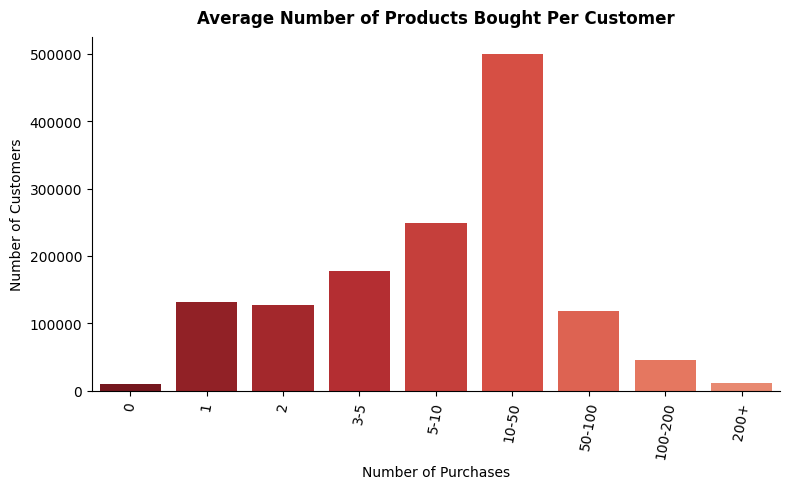

In [168]:
plt.figure(figsize=(8, 5))
num_categories=len(transaction_bins)
custom_palette = sns.color_palette('Reds', num_categories + 6)[6:][::-1]
g = sns.barplot(transaction_bins,
                x = "count_bin",
                y = "customers",
                hue="count_bin",
                palette=custom_palette)
g.tick_params(axis='x', labelrotation=80, labelsize=10);
g.set_xlabel("Number of Purchases")
g.set_ylabel("Number of Customers")
g.set_title("Average Number of Products Bought Per Customer", fontweight='bold', pad=10)
sns.despine()
plt.tight_layout()

In [145]:
transaction_bins

,count_bin,customers
0,0,9699
1,1,131514
2,2,127441
3,3-5,177768
4,5-10,249514
5,10-50,500252
6,50-100,118526
7,100-200,45790
8,200-500,10998
9,500+,478
